# Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.signal import convolve
from pathlib import Path

data_dir = Path('..') / "data"
img_dir = Path('..') / "img"

# Load the data
data = {}
for sphere in ['art', 'science', 'philo', 'spirit']:
    df = pd.read_csv(data_dir / f"{sphere}.csv" , sep="\t")
    df['sphere'] = sphere
    data[sphere] = df

# All data as spike trails
full_df = []
for sphere, df2 in data.items():
    # Interpolate the event data
    df = df2.copy()
    print(sphere)
    
    #df['Year'] = np.power(df['Year']/2000+1, 6)
    #df['Year'] = np.log(df['Year'].max()+20-df['Year']).round(2)
    df.loc[df['Year'].duplicated(), 'Year'] -= 1

    df.set_index('Year', inplace=True)
    df = df.reindex(np.arange(100*df.index.min(), 100*df.index.max())/100, method=None).fillna(0)
    df.Weight = 0.1*df.Weight
    df['sphere'] = sphere

    full_df.append(df)
full_df = pd.concat(full_df)

full_df

art
science
philo
spirit


,Idea/Movement,Influential Individuals,Continent,Weight,sphere
Year,,,,,
-2000.00,Ancient Egyptian Art,"Imhotep, Thutmose, Senenmut",Africa,0.9,art
-1999.99,0,0,0,0.0,art
-1999.98,0,0,0,0.0,art
-1999.97,0,0,0,0.0,art
-1999.96,0,0,0,0.0,art
...,...,...,...,...,...
1989.95,0,0,0,0.0,spirit
1989.96,0,0,0,0.0,spirit
1989.97,0,0,0,0.0,spirit


# Plot cumulative sum and exponential fit of all fields

params: a=29.96, b=0.000507


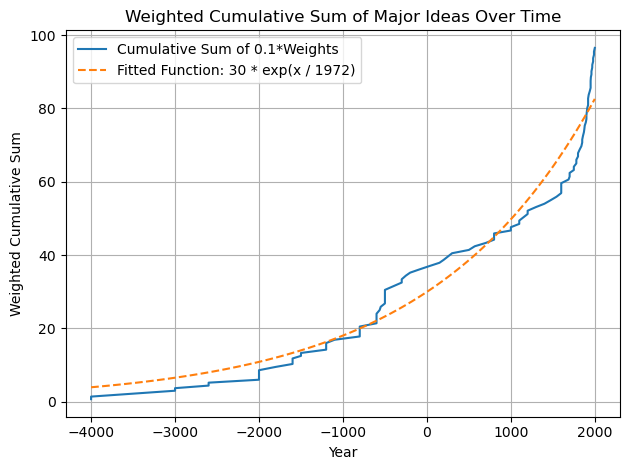

In [212]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

full_data = pd.concat(data.values()).sort_values('Year').set_index('Year')

# Compute the cumulative sum
cumulative_sum = 0.1 * full_data['Weight'].cumsum()
#cumulative_sum = (full_data['Weight'] / full_data['Weight']).cumsum()

# Define the exponential function to fit
def exponential_func(x, a, b):
    return a * np.exp(b * x)

def inv_exponential_func(x, a, b):
    return np.log(x / a) / b

# Fit the exponential function to the cumulative sum data
params, covariance = curve_fit(exponential_func, cumulative_sum.index, cumulative_sum.values, p0=[0.1, 0.001])
# params, covariance = curve_fit(polynomial_func, cumulative_sum.index, cumulative_sum.values, p0=[0.0005, 4, -4000])

print(f"params: a={params[0]:.2f}, b={params[1]:.6f}")

# Plot the cumulative sum
plt.plot(cumulative_sum, label='Cumulative Sum of 0.1*Weights')

# Plot the fitted exponential function
x_values = np.linspace(cumulative_sum.index.min(), cumulative_sum.index.max(), 100)
plt.plot(x_values, exponential_func(x_values, *params), label=f'Fitted Function: {params[0]:.0f} * exp(x / {1/params[1]:.0f})', linestyle='--')

# Add labels and legend
plt.title('Weighted Cumulative Sum of Major Ideas Over Time')
plt.xlabel('Year')
plt.ylabel('Weighted Cumulative Sum')
plt.legend()
plt.grid()
plt.tight_layout()

# Show the plot
plt.savefig(img_dir / "cumulative_sum.pdf")
plt.savefig(img_dir / "cumulative_sum.png")
plt.show()


# Plot smoothed smpact of art, science, philosophy, and religion

art
science
philo
spirit


<Figure size 1200x600 with 0 Axes>

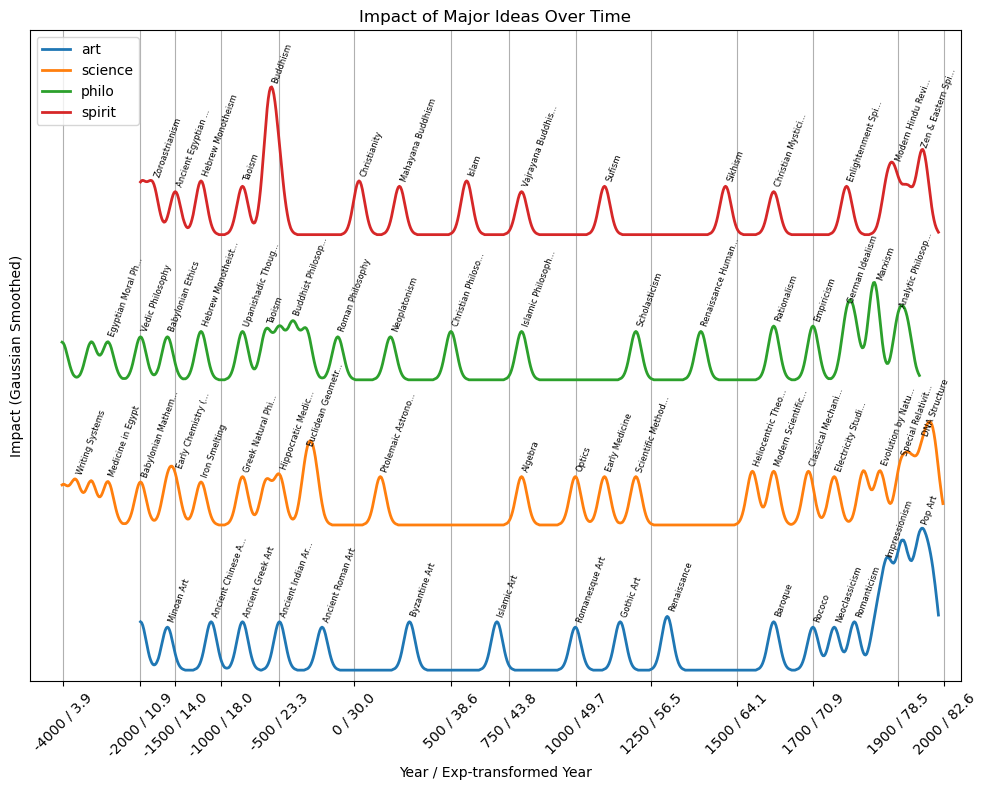

In [205]:
# Plot data
from scipy.signal import find_peaks

def gaussian_filter(series, dx, sigma=0.5):
    gx = np.arange(-3*sigma, 3*sigma, dx)
    gaussian = np.exp(-(gx/sigma)**2/2)
    result = np.convolve(series, gaussian, mode="same")
    return result

# Plot settings
plt.figure(figsize=(12, 6))

# Process each sphere
fig, ax = plt.subplots(figsize=(10,8))
count = 0
smoothed_dfs = {}
for sphere, df2 in data.items():
    # Interpolate the event data
    df = df2.copy()
    print(sphere)
    
    df['Year'] = exponential_func(df['Year'], *params).round(1)
    df.loc[df['Year'].duplicated(), 'Year'] -= 0.01

    df.set_index('Year', inplace=True)
    df = df.reindex(np.arange(10*df.index.min(), 10*df.index.max())/10, method=None).fillna(0)
    df.Weight = 0.1*df.Weight
    
    # Apply the Gamma filter to the interpolated series
    smoothed_series = gaussian_filter(df['Weight'].values, dx=(df.index.max()-df.index.min())/len(df))
    # smoothed_series = gamma_filter(df['Weight'].values, dx=(df.index.max()-df.index.min())/len(df))
    #smoothed_series = df['Weight'].values
    df['smoothed'] = smoothed_series
    smoothed_dfs[sphere] = df

    # Plot the smoothed series
    plt.plot(df.index, smoothed_series+2.7*count, label=sphere, linewidth=2)
    peaks, _ = find_peaks(df['Weight'].values, distance=17)
    for year, row in df.iloc[peaks].iterrows():
        if row['Idea/Movement'] != 0:
            plt.text(year, row.smoothed+2.7*count+0.1, 
                     row['Idea/Movement'][:17] + ("..." if len(row['Idea/Movement']) > 17 else ""), 
                     fontsize=6, rotation=70)
    count += 1


# Formatting the plot
plt.xlabel("Year / Exp-transformed Year")
#plt.gca().invert_xaxis()
#formatter = FuncFormatter(lambda x_val, tick_pos: "{:.0f}".format(2010-np.exp(x_val)))
plt.xlim(1, df.index.max()+2)

tick_positions = exponential_func(np.array(
    [-4000, -2000, -1500, -1000, -500, 0, 500, 750, 1000, 1250, 1500, 1700, 1900, 2000]
), *params)
plt.xticks(tick_positions, rotation=45)

formatter = FuncFormatter(lambda x_val, tick_pos: "{:.0f} / {x_val:.1f}".format(inv_exponential_func(x_val, *params), x_val=x_val))
ax.xaxis.set_major_formatter(formatter)

plt.yticks([])
plt.ylim(-0.2, 11.9)
plt.ylabel("Impact (Gaussian Smoothed)")
plt.title("Impact of Major Ideas Over Time")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.savefig(img_dir / "smoothed_impact.pdf")
plt.savefig(img_dir / "smoothed_impact.png")
plt.show()


# Calculate cross-correlation

art → spirit: 0.41/0.07
max_threshold1: 143.96, max_threshold2: 103.84
science → spirit: 1.23/0.56
max_threshold1: 121.96, max_threshold2: 62.81
spirit → philo: 2.57/2.72
max_threshold1: 102.18, max_threshold2: 47.76
science → art: 0.43/0.34
max_threshold1: 175.01, max_threshold2: 140.73
art → philo: 2.83/2.72
max_threshold1: 143.46, max_threshold2: 111.51
science → philo: 1.65/3.18
max_threshold1: 131.99, max_threshold2: 75.48


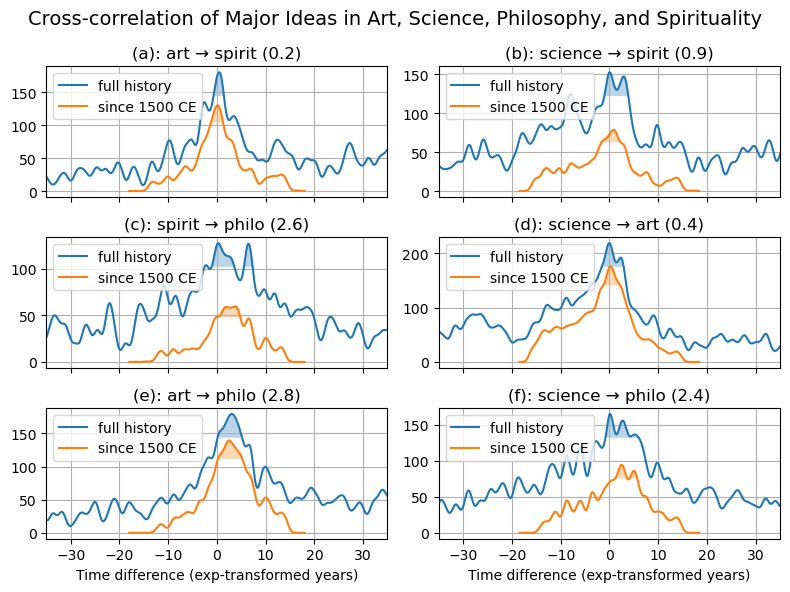

In [203]:
combinations = [
    ('art', 'spirit'),
    ('science', 'spirit'),
    ('spirit', 'philo'),
    ('science', 'art'),
    ('art', 'philo'),
    ('science', 'philo'),
]

enums = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

fig, ax = plt.subplots(3, 2, figsize=(8,6))


def correlate_dfs(df1, df2, colname):
    merged = df1.merge(df2, left_index=True, right_index=True, how='outer').fillna(0)
    corr = np.correlate(merged[f'{colname}_x'], merged[f'{colname}_y'], mode='full')
    index_shift = merged.index - np.min(merged.index)
    index_corr = np.linspace(-index_shift[-1], index_shift[-1], 2*len(index_shift)-1)
    return pd.Series(corr, index=index_corr)

def get_corr_shift(corr):
    # max_index = np.argmax(corr)
    # shift = corr.index[max_index]
    middle_idxs = np.where(np.abs(corr.index) < 40)
    #max_threshold = np.quantile(corr.iloc[middle_idxs], 0.95)
    max_threshold = 0.8 * np.max(corr.iloc[middle_idxs])
    max_idxs = np.where(corr > max_threshold)
    intersect_idxs = np.intersect1d(max_idxs, middle_idxs)
    shift = np.mean(corr.index[intersect_idxs] * (corr.iloc[intersect_idxs] - max_threshold)) / np.mean(corr.iloc[intersect_idxs] - max_threshold)
    #shift = np.mean(corr.index[intersect_idxs])
    return shift, max_threshold

for idx, combi in enumerate(combinations):
    # Compute the cross-correlation for full history
    corr1 = correlate_dfs(smoothed_dfs[combi[0]], smoothed_dfs[combi[1]], colname='smoothed')
    shift1, max_threshold1 = get_corr_shift(corr1)

    # Compute the cross-correlation since 0 CE
    years_threshold = 1500
    corr2 = correlate_dfs(
        smoothed_dfs[combi[0]][smoothed_dfs[combi[0]].index > exponential_func(years_threshold, *params)], 
        smoothed_dfs[combi[1]][smoothed_dfs[combi[1]].index > exponential_func(years_threshold, *params)], 
        colname='smoothed'
    )
    shift2, max_threshold2 = get_corr_shift(corr2)
    
    print(f"{combi[0]} → {combi[1]}: {shift1:.2f}/{shift2:.2f}")
    print(f"max_threshold1: {max_threshold1:.2f}, max_threshold2: {max_threshold2:.2f}")

    i = idx//2
    j = idx%2
    ax[i,j].plot(corr1, label=f'full history')
    ax[i,j].plot(corr2, label=f'since {years_threshold} CE')

    ax[i,j].fill_between(corr1.index, corr1, [max_threshold1]*len(corr1), where=(corr1 > max_threshold1), alpha=0.3)
    ax[i,j].fill_between(corr2.index, corr2, [max_threshold2]*len(corr2), where=(corr2 > max_threshold2), alpha=0.3)

    ax[i,j].grid(True)
    ax[i,j].legend(loc='upper left')
    ax[i,j].set_title(f"{enums[idx]}: {combi[0]} → {combi[1]} ({0.5*(shift1+shift2):.1f})")
    ax[i,j].set_xlim(-35, 35)
    #ax[i,j].set_yticks([])
    if i < 2:
        ax[i,j].set_xticklabels([])
    else:
        ax[i,j].set_xlabel("Time difference (exp-transformed years)")

fig.suptitle("Cross-correlation of Major Ideas in Art, Science, Philosophy, and Spirituality", fontsize=14)
plt.tight_layout()
plt.savefig(img_dir / "cross_correlation.pdf")
plt.savefig(img_dir / "cross_correlation.png")
plt.show()


# Print Time Difference Examples

transformed TD 2.8 at -2000: year TD 452
transformed TD 2.8 at 0: year TD 176
transformed TD 2.8 at 2000: year TD 66


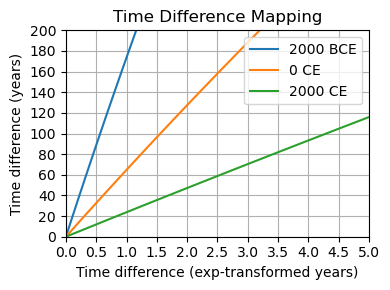

In [214]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))

years = [-2000, 0, 2000]
transformed_TD = np.linspace(0, 10, 100)
   
for year in years:
    year_transformed = exponential_func(year, *params)
    years_TD = [0]*len(transformed_TD)
    for i, td in enumerate(transformed_TD):
        years_TD[i] = inv_exponential_func(year_transformed + td, *params) - year
    plt.plot(transformed_TD, years_TD)
    print(f"transformed TD 2.8 at {year}: year TD {inv_exponential_func(year_transformed + 2.8, *params) - year:.0f}")

plt.title("Time Difference Mapping")
plt.ylabel("Time difference (years)")
plt.xlabel("Time difference (exp-transformed years)")
plt.xticks(np.arange(0, 10, 0.5))
plt.xlim(0, 5)
plt.yticks(np.arange(0, 1000, 20))
plt.ylim(0, 200)
plt.legend(["2000 BCE", "0 CE", "2000 CE"], loc='upper right')
plt.grid()
plt.tight_layout()

plt.savefig(img_dir / "time_difference_mapping.pdf")
plt.savefig(img_dir / "time_difference_mapping.png")
plt.show()


# Test cross-correlation function get_x_corr()

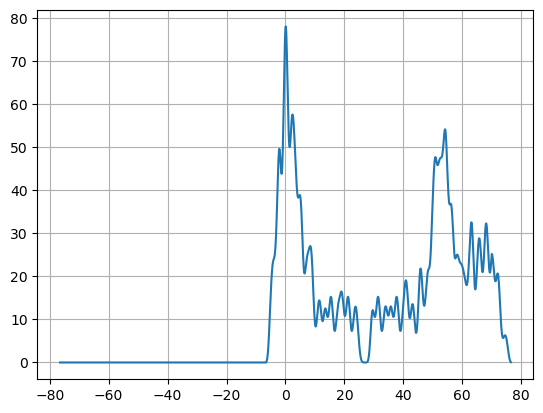

In [143]:
y1 = smoothed_dfs['philo']

corr = correlate_dfs(y1.iloc[700:], y1.iloc[:], colname='smoothed')
plt.plot(corr)
plt.grid()
plt.show()

# Print all data

In [211]:
from tabulate import tabulate


print(full_data.columns)
df = full_data.rename(columns={'sphere': 'Field'})[
    ['Field', 'Idea/Movement', 'Influential Individuals', 'Continent', 'Weight']
]

df['Influential Individuals'] = df['Influential Individuals'].apply(lambda x: x[:50] + ("..." if len(x) > 50 else ""))

data_txt = tabulate(df, headers='keys', tablefmt='psql')

with open(data_dir / "data.txt", "w") as f:
    f.write(data_txt)

print(data_txt)

Index(['Idea/Movement', 'Influential Individuals', 'Continent', 'Weight',
       'sphere'],
      dtype='object')
+--------+---------+----------------------------------------+-------------------------------------------------------+----------------------+----------+
|   Year | Field   | Idea/Movement                          | Influential Individuals                               | Continent            |   Weight |
|--------+---------+----------------------------------------+-------------------------------------------------------+----------------------+----------|
|  -4000 | philo   | Proto-Religious Thought                | Early Mesopotamian and Egyptian thinkers              | Middle East          |        7 |
|  -4000 | science | Early Metallurgy                       | Unnamed Sumerian and Egyptian metalworkers            | Middle East          |        7 |
|  -3500 | science | Writing Systems                        | Sumerians, Ancient Egyptians                          | Middle E